<a href="https://colab.research.google.com/github/jo-cho/advanced_in_financial_machine_learning/blob/master/Chapter_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chapter 10 Bet Sizing

# Exercises

In [0]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()

from scipy.stats import norm, moment

from dask.diagnostics import ProgressBar
ProgressBar().register()  # ready progress bar once in notebook for later calculations

from sklearn.neighbors import KernelDensity


In [0]:
# 멀티프로세싱

import time
import sys

def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

def nestedParts(numAtoms,numThreads,upperTriang=False):
    # partition of atoms with an inner loop
    parts,numThreads_=[0],min(numThreads,numAtoms)
    for num in range(numThreads_):
        part=1+4*(parts[-1]**2+parts[-1]+numAtoms*(numAtoms+1.)/numThreads_)
        part=(-1+part**.5)/2.
        parts.append(part)
    parts=np.round(parts).astype(int)
    if upperTriang: # the first rows are heaviest
        parts=np.cumsum(np.diff(parts)[::-1])
        parts=np.append(np.array([0]),parts)
    return parts
# =======================================================
# single-thread execution for debugging [20.8]
def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out
# =======================================================
# Example of async call to multiprocessing lib [20.9]
import multiprocessing as mp
import datetime as dt

#________________________________
def reportProgress(jobNum,numJobs,time0,task):
    # Report progress as asynch jobs are completed
    msg=[float(jobNum)/numJobs, (time.time()-time0)/60.]
    msg.append(msg[1]*(1/msg[0]-1))
    timeStamp=str(dt.datetime.fromtimestamp(time.time()))
    msg=timeStamp+' '+str(round(msg[0]*100,2))+'% '+task+' done after '+ \
        str(round(msg[1],2))+' minutes. Remaining '+str(round(msg[2],2))+' minutes.'
    if jobNum<numJobs:sys.stderr.write(msg+'\r')
    else:sys.stderr.write(msg+'\n')
    return
#________________________________
def processJobs(jobs,task=None,numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    outputs,out,time0=pool.imap_unordered(expandCall,jobs),[],time.time()
    # Process asyn output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out
# =======================================================
# Unwrapping the Callback [20.10]
def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out
# =======================================================
# Pickle Unpickling Objects [20.11]
def _pickle_method(method):
    func_name=method.im_func.__name__
    obj=method.im_self
    cls=method.im_class
    return _unpickle_method, (func_name,obj,cls)
#________________________________
def _unpickle_method(func_name,obj,cls):
    for cls in cls.mro():
        try:func=cls.__dict__[func_name]
        except KeyError:pass
        else:break
    return func.__get__(obj,cls)
#________________________________
def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func
    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)

    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

## 1. Using the formulation in Section 10.3, plot the bet size (m) as a function of the maximum predicted probability $(\tilde{p})$ when ‖X‖ = 2, 3,…, 10

- $ z = \frac{\tilde{p}− \frac{1}{‖X‖}}{\sqrt{p(1-\tilde{p})}} ∼Z $
- $ m = x (2Z [z] − 1) $


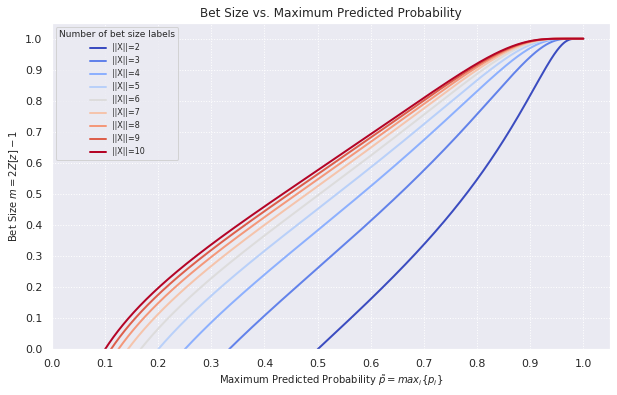

In [158]:
# This code is cloned from github.com/hudson-and-thames/research

num_classes_list = [i for i in range(2, 11, 1)]  # array of number of classes, 2 to 10
n = 10000  # number of points to plot
colors = iter(cm.coolwarm(np.linspace(0,1,len(num_classes_list))))

fig_10_1, ax_10_1 = plt.subplots(figsize=(10, 6))

for num_classes in num_classes_list:
    min_prob, max_prob = 1 / num_classes, 1  # possible range for maximum predicted probability, [1/||X||, 1] !!!그렇단다
    P = np.linspace(min_prob, max_prob, n, endpoint=False)  # range of maximum predicted probabilities to plot
    z = (P - min_prob) / (P*(1-P))**0.5
    m = 2 * norm.cdf(z) - 1
    ax_10_1.plot(P, m, label=f"||X||={num_classes}", linewidth=2, alpha=1, color=colors.__next__())

ax_10_1.set_ylabel("Bet Size $m=2Z[z]-1$", fontsize=10)
ax_10_1.set_xlabel(r"Maximum Predicted Probability $\tilde{p}=max_i${$p_i$}", fontsize=10)
ax_10_1.set_title("Bet Size vs. Maximum Predicted Probability", fontsize=12)
ax_10_1.set_xticks([0.1*i for i in range(11)])
ax_10_1.set_yticks([0.1*i for i in range(11)])
ax_10_1.legend(loc="upper left", fontsize=8, title="Number of bet size labels", title_fontsize=9)
ax_10_1.set_ylim((0,1.05))
ax_10_1.set_xlim((0, 1.05))
ax_10_1.grid(linewidth=1, linestyle=':')

plt.show()

예측된 최대 확률로 나타낸 bet size의 함수이다. long만 생각한 것이다. 당연히 예상되는 최대 확률이 높으면 bet size가 커진다. 최대확률이 $\frac{1}{||X||}$ 보다 작으면 베팅하지 않는다. 

--Note--

$||X||$가 클수록 bet size를 1로 놓는 순간이 빠르다, since the greater number of alternative bets spreads the remaining probability much thinner, leading to a greater confidence in that with the maximum predicted probability.

## 2. Draw 10,000 random numbers from a uniform distribution with bounds U[.5, 1.]. (Author's note: These exercises are intended to simulate dynamic bet sizing of a long-only strategy.)

In [0]:
# draw random numbers from a uniform distribution (all bets are long)
np.random.seed(0)
n = 10000
P_t = np.random.uniform(.5, 1., n)  # array of random from uniform dist.

### (a) Compute bet sizes m for $||X||=2$.

In [160]:
z = (P_t - 1/2) /  (P_t*(1-P_t))**0.5
m = 2 * norm.cdf(z) - 1
m

array([0.48850964, 0.69381609, 0.55000197, ..., 0.75544329, 0.0189832 ,
       0.83824514])

### (b) Assign 10,000 consecutive calendar days

In [161]:
start_date = dt.datetime(1992, 7, 22)  # starting at 01-JAN-1992
date_step = dt.timedelta(days=1)
dates = np.array([start_date + i*date_step for i in range(n)])
bet_sizes = pd.Series(data=m, index=dates)
bet_sizes

1992-07-22    0.488510
1992-07-23    0.693816
1992-07-24    0.550002
1992-07-25    0.484193
1992-07-26    0.360002
                ...   
2019-12-03    0.490310
2019-12-04    0.334799
2019-12-05    0.755443
2019-12-06    0.018983
2019-12-07    0.838245
Length: 10000, dtype: float64

### (c) Draw 10,000 random numbers from a uniform distribution with bounds U[1, 25].

In [0]:
# 재미를 위해 25 대신 10으로 하겠다.

rn = np.random.uniform(1, 10, n)
rn = rn.round()

### (d) Form a pandas.Series indexed by the dates in 2.b, and with values equal to the index shifted forward the number of days in 2.c. This is a t1 object similar to the ones we used in Chapter 3.

In [163]:
shift_day = np.array([dt.timedelta(days=ndays) for ndays in rn])
shift_day

array([datetime.timedelta(8), datetime.timedelta(3),
       datetime.timedelta(5), ..., datetime.timedelta(5),
       datetime.timedelta(4), datetime.timedelta(7)], dtype=object)

In [164]:
dates_shifted = dates + shift_day

t1 = pd.Series(data=dates_shifted, index=dates)
t1

1992-07-22   1992-07-30
1992-07-23   1992-07-26
1992-07-24   1992-07-29
1992-07-25   1992-07-26
1992-07-26   1992-07-27
                ...    
2019-12-03   2019-12-11
2019-12-04   2019-12-08
2019-12-05   2019-12-10
2019-12-06   2019-12-10
2019-12-07   2019-12-14
Length: 10000, dtype: datetime64[ns]

In [165]:
df_events = pd.concat(objs=[t1, bet_sizes], axis=1)
df_events = df_events.rename(columns={0: 't1', 1: 'bet_size'})
df_events['p'] = P_t
df_events = df_events[['t1', 'p', 'bet_size']]
df_events.head()

,t1,p,bet_size
1992-07-22,1992-07-30,0.774407,0.488510
1992-07-23,1992-07-26,0.857595,0.693816
1992-07-24,1992-07-29,0.801382,0.550002
1992-07-25,1992-07-26,0.772442,0.484193
1992-07-26,1992-07-27,0.711827,0.360002


### (e) Compute the resulting average active bets, following Section 10.4.

what is average active bets?

어느날 기준, 그 전날 중에서 t1이 어느날보다 뒤인 날들의 bet size들을 포함해 평균 낸 것.
즉 과거에 베팅한 것들이 남아있을 때 그 베팅사이즈들도 고려해 평균 낸 것을 말한다.  

In [166]:
df_events = df_events.rename(columns={'bet_size': 'signal'})
df_events.head()

,t1,p,signal
1992-07-22,1992-07-30,0.774407,0.488510
1992-07-23,1992-07-26,0.857595,0.693816
1992-07-24,1992-07-29,0.801382,0.550002
1992-07-25,1992-07-26,0.772442,0.484193
1992-07-26,1992-07-27,0.711827,0.360002


In [0]:
def mpAvgActiveSignals(signals,molecule):
  '''
  At time loc, average signal among those still active.
  Signal is active if:
  a) issued before or at loc AND
  b) loc before signal's endtime, or endtime is still unknown (NaT).
  '''

  out=pd.Series()
  for loc in molecule:
    df0=(signals.index.values<=loc)&((loc<signals['t1'])|pd.isnull(signals['t1']))
    act=signals[df0].index
    if len(act)>0:
      out[loc]=signals.loc[act,'signal'].mean()
    else:
      out[loc]=0 # no signals active at this time
  return out

In [0]:
def avgActiveSignals(signals,numThreads):
# compute the average signal among those active
#1) time points where signals change (either one starts or one ends)
  tPnts=set(signals['t1'].dropna().values)
  tPnts=tPnts.union(signals.index.values)
  tPnts=list(tPnts);tPnts.sort()
  
  out=mpPandasObj(mpAvgActiveSignals,('molecule',tPnts),numThreads,signals=signals)
  return out

In [169]:
active = avgActiveSignals(signals=df_events,numThreads=12)

2019-12-07 14:09:44.246460 100.0% mpAvgActiveSignals done after 0.52 minutes. Remaining 0.0 minutes.


In [0]:
#두번째 방법 from hudson-thames --> 매우 느림

#avg_bet = pd.Series()
#active_bets = pd.Series()
#for idx, val in t1.iteritems():
#    active_idx = t1[(t1.index<=idx)&(t1>idx)].index
#    num_active = len(active_idx)
#    active_bets[idx] = num_active
#    avg_bet[idx] = bet_sizes[active_idx].mean()


In [170]:
print("The resulting DataFrame from Exercise 10.2:")
df_events = df_events.rename(columns={'signal':'bet size'})
df_events['avg active bets'] = active
df_events.head(10)

The resulting DataFrame from Exercise 10.2:


,t1,p,bet size,avg active bets
1992-07-22,1992-07-30,0.774407,0.488510,0.488510
1992-07-23,1992-07-26,0.857595,0.693816,0.591163
1992-07-24,1992-07-29,0.801382,0.550002,0.577443
1992-07-25,1992-07-26,0.772442,0.484193,0.554130
1992-07-26,1992-07-27,0.711827,0.360002,0.466171
1992-07-27,1992-08-06,0.822947,0.602473,0.546995
1992-07-28,1992-08-02,0.718794,0.373496,0.503620
1992-07-29,1992-08-02,0.945887,0.951258,0.603934
1992-07-30,1992-08-02,0.981831,0.999691,0.731729
1992-07-31,1992-08-08,0.691721,0.321986,0.649781


## 3. Using the $t1$ object from exercise 2.d:

### (a) Determine the maximum number of concurrent long bets, $\bar{c}_l$.

In [0]:
df_events2 = df_events.copy()
active_long = pd.Series()

for idx in df_events2.index:    
    # long bets are defined as having a prediction probability greater than or equal to 0.75
    df_long_active_idx = set(df_events2[(df_events2.index<=idx) & (df_events2.t1>idx) & (df_events2.p>=0.75)].index)
    active_long[idx] = len(df_long_active_idx)

In [172]:
print(active_long.head(5), 2*'\n','num of max concurrent long :',active_long.max())

1992-07-22    1
1992-07-23    2
1992-07-24    3
1992-07-25    4
1992-07-26    2
dtype: int64 

 num of max concurrent long : 7


In [173]:
len(active_short)

10000

### (b) Determine the maximum number of concurrent short bets, $c_s$

In [0]:
active_short = pd.Series()

for idx in df_events2.index:    
    # short bets are defined as having a prediction probability less than 0.75
    df_short_active_idx = set(df_events2[(df_events2.index<=idx) & (df_events2.t1>idx) & (df_events2.p<0.75)].index)
    active_short[idx] = len(df_short_active_idx)

In [175]:
print(active_short.head(5),2*'\n', '- num of max concurrent short :', active_short.max())

1992-07-22    0
1992-07-23    0
1992-07-24    0
1992-07-25    0
1992-07-26    1
dtype: int64 

 - num of max concurrent short : 8


### (c) Derive the bet size as $m_t = c_{t,l} \frac1{\bar{c}_l}- c_{t,s}\frac1{\bar{c}_s}$, where $c_{t,l}$ is the number of concurrent long bets at time t, and $c_{t,s}$ is the number of concurrent short bets at time t.

In [176]:
bet_size2 = pd.Series()
bet_size2 = active_long/active_long.max() - active_short*1/active_short.max()
bet_size2.head()

1992-07-22    0.142857
1992-07-23    0.285714
1992-07-24    0.428571
1992-07-25    0.571429
1992-07-26    0.160714
dtype: float64

In [177]:
np.all(df_events2.index == active_long.index)

True

In [178]:
#overview

df_events2= df_events2.assign(num_of_concurrent_long = active_long,num_of_concurrent_short=active_short,bet_size2=bet_size2)
df_events2

,t1,p,bet size,avg active bets,num_of_concurrent_long,num_of_concurrent_short,bet_size2
1992-07-22,1992-07-30,0.774407,0.488510,0.488510,1,0,0.142857
1992-07-23,1992-07-26,0.857595,0.693816,0.591163,2,0,0.285714
1992-07-24,1992-07-29,0.801382,0.550002,0.577443,3,0,0.428571
1992-07-25,1992-07-26,0.772442,0.484193,0.554130,4,0,0.571429
1992-07-26,1992-07-27,0.711827,0.360002,0.466171,2,1,0.160714
...,...,...,...,...,...,...,...
2019-12-03,2019-12-11,0.775223,0.490310,0.477373,4,3,0.196429
2019-12-04,2019-12-08,0.698576,0.334799,0.430025,3,4,-0.071429
2019-12-05,2019-12-10,0.879215,0.755443,0.434725,3,3,0.053571
2019-12-06,2019-12-10,0.511894,0.018983,0.422658,3,3,0.053571


## 4. Using the $t1$ object from exercise 2.d:

###(a) Compute the series $c_t = c_{t,l} − c_{t,s}$, where $c_{t,l}$ is the number of concurrent long bets at time $t$, and $c_{t,s}$ is the number of concurrent short bets at time $t$

In [179]:
c = pd.Series()
c = active_long - active_short
c.head()

1992-07-22    1
1992-07-23    2
1992-07-24    3
1992-07-25    4
1992-07-26    1
dtype: int64

In [180]:
df_events2['c_t'] = c
df_events2.head()

,t1,p,bet size,avg active bets,num_of_concurrent_long,num_of_concurrent_short,bet_size2,c_t
1992-07-22,1992-07-30,0.774407,0.488510,0.488510,1,0,0.142857,1
1992-07-23,1992-07-26,0.857595,0.693816,0.591163,2,0,0.285714,2
1992-07-24,1992-07-29,0.801382,0.550002,0.577443,3,0,0.428571,3
1992-07-25,1992-07-26,0.772442,0.484193,0.554130,4,0,0.571429,4
1992-07-26,1992-07-27,0.711827,0.360002,0.466171,2,1,0.160714,1


### (b) Fit a mixture of two Gaussians on {$c_t$}. You may want to use the method described in Lopez de Prado and Foreman [2014].

from Lopez de Prado and Foreman [2014]

use EF3M algo, check https://github.com/jo-cho/research/tree/master/Chapter10/EF3M

I'll just skip this one

### (c) 

In [0]:
#F(x)함수 : x의 두 가우스분포 mixture의 CDF 함수

def cdf_mixture(x, parameters):
    # the CDF of a mixture of 2 normal distributions, evaluated at x
    # :param x: (float) x-value
    # :param parameters: (list) mixture parameters, [mu1, mu2, sigma1, sigma2, p1]
    # :return: (float) CDF of the mixture
    # ===================================
    mu1, mu2, sigma1, sigma2, p1 = parameters  # for clarity
    return p1*norm.cdf(x, mu1, sigma1) + (1-p1)*norm.cdf(x, mu2, sigma2)

In [182]:
cdf_mixture(c,parameters)

array([0.56527933, 0.7944261 , 0.90929731, ..., 0.32932763, 0.32932763,
       0.56527933])

$m_t = \begin{cases}
  \frac{F[c_t]-F[0]}{1-F[0]} & \text{if}\ c_t \ge 0 \\
  \frac{F[c_t]-F[0]}{F[0]} & \text{if}\ c_t < 0
\end{cases}$

In [0]:
#위의 식

def bet_size_mixed(c_t, parameters):
    # return the bet size based on the description provided in
    # question 10.4(c).
    # :param c_t: (int) different of the number of concurrent long bets minus short bets
    # :param parameters: (list) mixture parameters, [mu1, mu2, sigma1, sigma2, p1]
    # :return: (float) bet size
    # =========================
    if c_t >= 0:
        return ( cdf_mixture(c_t, parameters) - cdf_mixture(0, parameters) ) / ( 1 - cdf_mixture(0, parameters) )
    else:
        ( cdf_mixture(c_t, parameters) - cdf_mixture(0, parameters) ) / cdf_mixture(0, parameters)

In [184]:
# 밑의 파라미터는 hudson-thames 연구에서 도출한 fitted parameters 들이다.
# Most probable estimate for parameter 'mu1': 12.574
# Most probable estimate for parameter 'mu2': 13.39
# Most probable estimate for parameter 'sigma1': 3.306
# Most probable estimate for parameter 'sigma2': 1.95
# Most probable estimate for parameter 'p1': 0.017
parameters = [0,1,3,1,0.5]
#대충 때려넣어 봤다.

bet_size3 = pd.Series()
bet_size3 = df_events2.c_t.apply(lambda c: bet_size_mixed(c, parameters))
df_events2['bet_size3'] = bet_size3
df_events2.head()

,t1,p,bet size,avg active bets,num_of_concurrent_long,num_of_concurrent_short,bet_size2,c_t,bet_size3
1992-07-22,1992-07-30,0.774407,0.488510,0.488510,1,0,0.142857,1,0.351814
1992-07-23,1992-07-26,0.857595,0.693816,0.591163,2,0,0.285714,2,0.693481
1992-07-24,1992-07-29,0.801382,0.550002,0.577443,3,0,0.428571,3,0.864759
1992-07-25,1992-07-26,0.772442,0.484193,0.554130,4,0,0.571429,4,0.930994
1992-07-26,1992-07-27,0.711827,0.360002,0.466171,2,1,0.160714,1,0.351814


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Figure 10.4(c): Bet Size distributions from exercises 10.3 and 10.4')

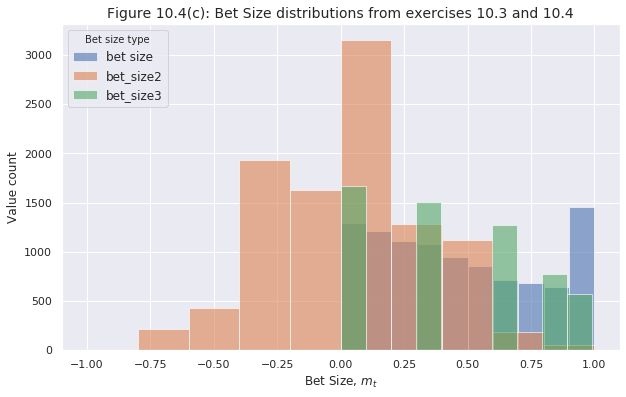

In [185]:
fig_10_4c, ax_10_4c = plt.subplots(figsize=(10,6))
for c in ['bet size','bet_size2', 'bet_size3']:
    ax_10_4c.hist(df_events2[c],  label=c, alpha=0.6)
ax_10_4c.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax_10_4c.set_xlabel("Bet Size, $m_t$", fontsize=12)
ax_10_4c.set_ylabel("Value count", fontsize=12)
ax_10_4c.set_title("Figure 10.4(c): Bet Size distributions from exercises 10.3 and 10.4", fontsize=14)

### 5. Repeat exercise 1, where you discretize m with a stepSize=.01 stepSize=.05, and stepSize=.1.

In [0]:
def discreteSignal(signal0,stepSize):
  
  # discretize signal
  signal1=(signal0/stepSize).round()*stepSize # discretize
  signal1[signal1>1]=1 # cap
  signal1[signal1<-1]=-1 # floor
  
  return signal1

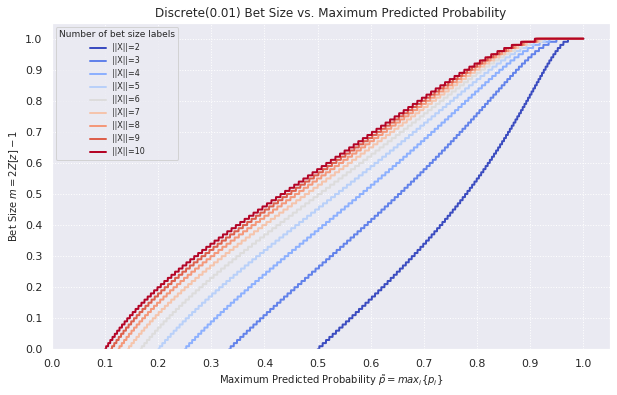

In [187]:
# exercise 1
# This code is cloned from github.com/hudson-and-thames/research

num_classes_list = [i for i in range(2, 11, 1)]  # array of number of classes, 2 to 10
n = 10000  # number of points to plot

stepSize = 0.01

colors = iter(cm.coolwarm(np.linspace(0,1,len(num_classes_list))))

fig_10_5, ax_10_5 = plt.subplots(figsize=(10, 6))

for num_classes in num_classes_list:
    min_prob, max_prob = 1 / num_classes, 1  # possible range for maximum predicted probability, [1/||X||, 1] !!!그렇단다
    P = np.linspace(min_prob, max_prob, n, endpoint=False)  # range of maximum predicted probabilities to plot
    z = (P - min_prob) / (P*(1-P))**0.5
    m = 2 * norm.cdf(z) - 1
    discrete_m = discreteSignal(m,stepSize) ## discretized
    ax_10_5.plot(P, discrete_m, label=f"||X||={num_classes}", linewidth=2, alpha=1, color=colors.__next__())

ax_10_5.set_ylabel("Bet Size $m=2Z[z]-1$", fontsize=10)
ax_10_5.set_xlabel(r"Maximum Predicted Probability $\tilde{p}=max_i${$p_i$}", fontsize=10)
ax_10_5.set_title("Discrete(0.01) Bet Size vs. Maximum Predicted Probability", fontsize=12)
ax_10_5.set_xticks([0.1*i for i in range(11)])
ax_10_5.set_yticks([0.1*i for i in range(11)])
ax_10_5.legend(loc="upper left", fontsize=8, title="Number of bet size labels", title_fontsize=9)
ax_10_5.set_ylim((0,1.05))
ax_10_5.set_xlim((0, 1.05))
ax_10_5.grid(linewidth=1, linestyle=':')

plt.show()

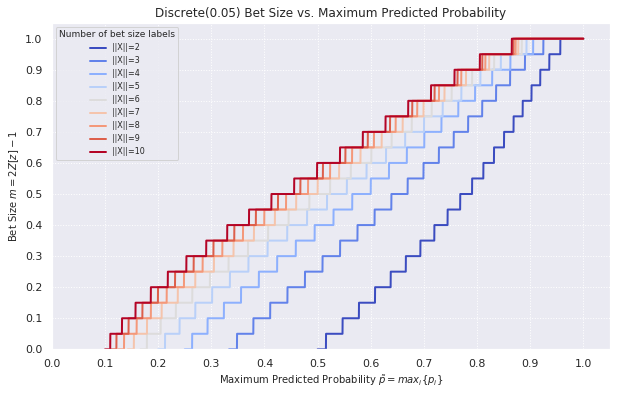

In [188]:
stepSize = 0.05
colors = iter(cm.coolwarm(np.linspace(0,1,len(num_classes_list))))

fig_10_52, ax_10_52 = plt.subplots(figsize=(10, 6))

for num_classes in num_classes_list:
    min_prob, max_prob = 1 / num_classes, 1  # possible range for maximum predicted probability, [1/||X||, 1] !!!그렇단다
    P = np.linspace(min_prob, max_prob, n, endpoint=False)  # range of maximum predicted probabilities to plot
    z = (P - min_prob) / (P*(1-P))**0.5
    m = 2 * norm.cdf(z) - 1
    discrete_m = discreteSignal(m,stepSize) ## discretized
    ax_10_52.plot(P, discrete_m, label=f"||X||={num_classes}", linewidth=2, alpha=1, color=colors.__next__())

ax_10_52.set_ylabel("Bet Size $m=2Z[z]-1$", fontsize=10)
ax_10_52.set_xlabel(r"Maximum Predicted Probability $\tilde{p}=max_i${$p_i$}", fontsize=10)
ax_10_52.set_title("Discrete(0.05) Bet Size vs. Maximum Predicted Probability", fontsize=12)
ax_10_52.set_xticks([0.1*i for i in range(11)])
ax_10_52.set_yticks([0.1*i for i in range(11)])
ax_10_52.legend(loc="upper left", fontsize=8, title="Number of bet size labels", title_fontsize=9)
ax_10_52.set_ylim((0,1.05))
ax_10_52.set_xlim((0, 1.05))
ax_10_52.grid(linewidth=1, linestyle=':')

plt.show()

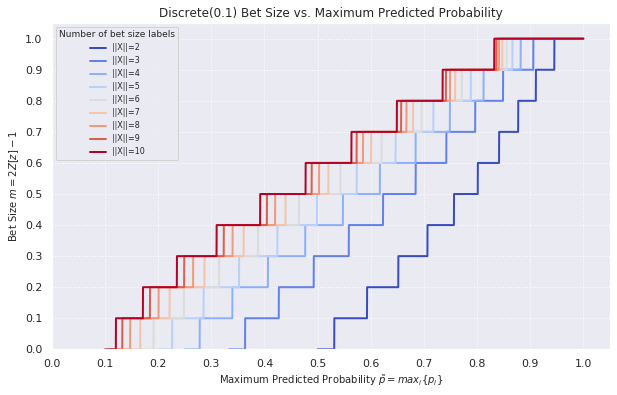

In [189]:
stepSize = 0.1
colors = iter(cm.coolwarm(np.linspace(0,1,len(num_classes_list))))

fig_10_52, ax_10_52 = plt.subplots(figsize=(10, 6))

for num_classes in num_classes_list:
    min_prob, max_prob = 1 / num_classes, 1  # possible range for maximum predicted probability, [1/||X||, 1] !!!그렇단다
    P = np.linspace(min_prob, max_prob, n, endpoint=False)  # range of maximum predicted probabilities to plot
    z = (P - min_prob) / (P*(1-P))**0.5
    m = 2 * norm.cdf(z) - 1
    discrete_m = discreteSignal(m,stepSize) ## discretized
    ax_10_52.plot(P, discrete_m, label=f"||X||={num_classes}", linewidth=2, alpha=1, color=colors.__next__())

ax_10_52.set_ylabel("Bet Size $m=2Z[z]-1$", fontsize=10)
ax_10_52.set_xlabel(r"Maximum Predicted Probability $\tilde{p}=max_i${$p_i$}", fontsize=10)
ax_10_52.set_title("Discrete(0.1) Bet Size vs. Maximum Predicted Probability", fontsize=12)
ax_10_52.set_xticks([0.1*i for i in range(11)])
ax_10_52.set_yticks([0.1*i for i in range(11)])
ax_10_52.legend(loc="upper left", fontsize=8, title="Number of bet size labels", title_fontsize=9)
ax_10_52.set_ylim((0,1.05))
ax_10_52.set_xlim((0, 1.05))
ax_10_52.grid(linewidth=1, linestyle=':')

plt.show()

## 6. Rewrite the equations in Section 10.6, so that the bet size is determined by a power function rather than a sigmoid function.

Let's see what we got in Section 10.6

Let $q_t$ be the current position, $Q$ the maximum absolute position size, and ̂$q_{i,t}$ the target position size associated with forecast $f_i$, such that

$$\hat{q}_{i,t} = \text{int}[m[\omega,f_i − p_t]Q]\\
m[\omega, x] = \frac{x}{\sqrt{𝜔 + x^2}}$$

where m[𝜔, x] is the bet size, x = fi − pt is the divergence between the current market
price and the forecast, 𝜔 is a coefficient that regulates the width of the sigmoid function,
and Int [x] is the integer value of x. Note that for a real-valued price divergence
x, −1 < m[𝜔, x] < 1, the integer value $\hat{q}_{i,t}$ is bounded −Q < ̂qi,t < Q.

The target position size ̂qi,t can be dynamically adjusted as pt changes. In particular,
as pt → fi we get ̂qi,t → 0, because the algorithm wants to realize the gains. This implies a breakeven limit price ̄p for the order size ̂qi,t − qt, to avoid realizing losses. In particular,

$$ \hat{p} = \frac{1}{q_{i,t} − q_{t}} \displaystyle\sum_{j=\mid q_t+sgn[\hat{q}_{i,t}-q_t]\mid}^{\mid\hat{q}_{i,t}\mid}{L[f_i,\omega,\frac{j}{Q}]} $$

where L[fi,𝜔,m] is the inverse function of m[𝜔, fi − pt] with respect to pt,

$$ L[f_i,𝜔,m] = f_i − m\sqrt{\frac{𝜔}{1−m^2}} $$

We do not need to worry about the case m^2 = 1, because $|\hat{q}_i,t| < 1$. Since this
function is monotonic, the algorithm cannot realize losses as pt → fi.

Let us calibrate $𝜔$. Given a user-defined pair $(x,m^∗)$, such that $x = f_i − p_t$ and $m^∗ = m[𝜔, x]$, the inverse function of m[𝜔, x] with respect to 𝜔 is
$$
𝜔 = x^2(m^{∗−2} − 1)
$$

In [0]:
# Now let us rewrite
# 이것도 역시 hudson-thames 출처


We can substitute a power function to calculate bet size, $\tilde{m}$:

$$\tilde{m}[\omega, x] = sgn[x]|x|^\omega$$
$L[f_i, \omega, \tilde{m}]$, the inverse function of $\tilde{m}[\omega, x]$ with respect to the market price $p_t$, can be rewritten as:

$$L[f_i, \omega, \tilde{m}] = f_i - sgn[\tilde{m}]|\tilde{m}|^{1/\omega}$$
The inverse of $\tilde{m}[\omega, x]$ with respect to $\omega$ can be rewritten as:

$$\omega = \frac{log[\frac{\tilde{m}}{sgn(x)}]}{log[|x|]}$$
Where $x = f_i - p_t$ is still the divergence between the current market price, $p_t$, and the price forecast, $f_i$.

## 7. Modify Snippet 10.4 so that it implements the equations you derived in exercise 6


In [0]:
# Snippet 10.4

def betSize(w,x):
  return x*(w+x**2)**-.5
#———————————————————————————————————————
def getTPos(w,f,mP,maxPos):
  return int(betSize(w,f-mP)*maxPos)
#———————————————————————————————————————
def invPrice(f,w,m):
  return f-m*(w/(1-m**2))**.5
#———————————————————————————————————————
def limitPrice(tPos,pos,f,w,maxPos):
  sgn=(1 if tPos>=pos else -1)
  lP=0
  for j in range(abs(pos+sgn),abs(tPos+1)):
    lP+=invPrice(f,w,j/float(maxPos))
  lP/=tPos-pos
  return lP
#———————————————————————————————————————
def getW(x,m):
  # 0<alpha<1
  return (x**2)*((m**(-2))-1)
#———————————————————————————————————————
def main():
  pos,maxPos,mP,f,wParams=0,100,100,115,{'divergence':10,'m':.95}
  w=getW(wParams['divergence'],wParams['m']) # calibrate w
  tPos=getTPos(w,f,mP,maxPos) # get tPos
  lP=limitPrice(tPos,pos,f,w,maxPos) # limit price for order
  return w, tPos, lP
#———————————————————————————————————————
if __name__=='__main__':main()


In [192]:
main()

(10.803324099723, 97, 112.36573855883363)

Let us modify

In [0]:
# New one

def betSize(w,x):
  return np.sign(x)*(np.abs(x)**w)
#———————————————————————————————————————
def getTPos(w,f,mP,maxPos):
  return int(betSize(w,f-mP)*maxPos)
#———————————————————————————————————————
def invPrice(f,w,m):
  return f-np.sign(m)*(np.abs(m)**(1/w))
#———————————————————————————————————————
def limitPrice(tPos,pos,f,w,maxPos):
  sgn=(1 if tPos>=pos else -1)
  lP=0
  for j in range(abs(pos+sgn),abs(tPos+1)):
    lP+=invPrice(f,w,j/float(maxPos))
  lP/=tPos-pos
  return lP
#———————————————————————————————————————
def getW(x,m):
  # 0<alpha<1
  return np.log(m/np.sign(x))/np.log(np.abs(x))
#———————————————————————————————————————
def main2():
  pos,maxPos,mP,f,wParams=0,100,100,115,{'divergence':10,'m':.95}
  w=getW(wParams['divergence'],wParams['m']) # calibrate w
  tPos=getTPos(w,f,mP,maxPos) # get tPos
  lP=limitPrice(tPos,pos,f,w,maxPos) # limit price for order
  return w, tPos, lP
#———————————————————————————————————————
if __name__=='__main__':main()

In [194]:
main2()

(-0.02227639471115225, 94, -6.426982348112109e+87)

# Trash bin

In [0]:
# meta-labeling을 불러오자.

#from google.colab import drive
#drive.mount('/content/drive')

In [196]:
'''
!pip install -q mlfinlab
from mlfinlab import data_structures, features, filters, labeling

#달러 바 만들기 (close)
raw_dollar_bars = data_structures.get_dollar_bars('/content/drive/My Drive/Colab Notebooks/csv/clean_IVE_tickbidask2.csv', threshold=1000000)

dollar_bars = raw_dollar_bars.set_index(pd.to_datetime(raw_dollar_bars.date_time))
dollar_bars = dollar_bars.drop(columns='date_time')
dollar_bars = dollar_bars.reset_index().drop_duplicates(subset='date_time', keep='last').set_index('date_time')
close = dollar_bars.close

#Horizontal barrier (pt_sl)
pt_sl = [1,1]

#barrier target (target)
def getDailyVol(close,span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    #bp()
    df0=df0[df0>0]
    #bp()
    df0=(pd.Series(close.index[df0-1],
                   index=close.index[close.shape[0]-df0.shape[0]:]))
    #bp()
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(e)
        print('adjusting shape of close.loc[df0.index]')
        cut = close.loc[df0.index].shape[0] - close.loc[df0.values].shape[0]
        df0=close.loc[df0.index].iloc[:-cut]/close.loc[df0.values].values-1
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

target = getDailyVol(close)

#t_events
h = target.mean()
t_events = filters.cusum_filter(close,h)

#vertical_barrier
vertical_barrier = labeling.add_vertical_barrier(t_events,close,num_days=1)

#side 정하기
fast_window = 3
slow_window = 6
close_df = (pd.DataFrame()
            .assign(price=close)
            .assign(fast=close.ewm(fast_window).mean())
            .assign(slow=close.ewm(slow_window).mean()))
def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]
def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

up = get_up_cross(close_df)
down = get_down_cross(close_df)

side_up = pd.Series(1, index=up.index)
side_down = pd.Series(-1, index=down.index)
side = pd.concat([side_up,side_down]).sort_index()

# Get Events
events = labeling.get_events(close, t_events, pt_sl, target, min_ret=0.01, num_threads=1 , vertical_barrier_times=vertical_barrier, side_prediction=side )
'''

"\n!pip install -q mlfinlab\nfrom mlfinlab import data_structures, features, filters, labeling\n\n#달러 바 만들기 (close)\nraw_dollar_bars = data_structures.get_dollar_bars('/content/drive/My Drive/Colab Notebooks/csv/clean_IVE_tickbidask2.csv', threshold=1000000)\n\ndollar_bars = raw_dollar_bars.set_index(pd.to_datetime(raw_dollar_bars.date_time))\ndollar_bars = dollar_bars.drop(columns='date_time')\ndollar_bars = dollar_bars.reset_index().drop_duplicates(subset='date_time', keep='last').set_index('date_time')\nclose = dollar_bars.close\n\n#Horizontal barrier (pt_sl)\npt_sl = [1,1]\n\n#barrier target (target)\ndef getDailyVol(close,span0=100):\n    # daily vol reindexed to close\n    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))\n    #bp()\n    df0=df0[df0>0]\n    #bp()\n    df0=(pd.Series(close.index[df0-1],\n                   index=close.index[close.shape[0]-df0.shape[0]:]))\n    #bp()\n    try:\n        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily ret